## Implicit Schemes

Discretized equation:
$$
\frac{T_{i}^{n+1}-T_{i}^{n}}{\Delta t}=\alpha\frac{T_{i+1}^{n+1}-2T_{i}^{n+1}+T_{i-1}^{n+1}}{\Delta x^2}.
$$

### BCs

### Problem Set-up
The graphite rod, same as the previous lesson.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# set the font family and size to use for Matplotlib figures
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# set parameters
L = 1.0  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
alpha = 1.22e-3  #  thermal diffusivity of the rod
q = 0.0  # temperature gradient on the right side of the rod

# define the locations along the rod
x = numpy.linspace(0.0, L, num=nx)

# set the initial temperature along the rod
T0 = numpy.zeros(nx)
T0[0] = 100.0

In [4]:
from scipy import linalg

In [5]:
def lhs_operator(N, sigma):
    """
    Computes and returns the implicit operator of the system for the 
    1D diffusion equation. We use backward Euler method, Dirichlet 
    condition on the left side of the domain and zero-gradient Neumann 
    condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points
    sigma : float
        Value of alpha * dt / dx**2
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats of size N by N
    """
    
    # setup the diagonal of the operator
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    
    # setup the Neumann condition for the last element
    D[-1, -1] = 1.0 + 1.0 / sigma
    
    # setup the upper diagonal of the operator
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    
    # setup the lower diagonal of the operator
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    
    # assemble the operator
    A = D + U + L
    
    return A

In [6]:
def rhs_vector(T, sigma, qdx):
    """
    Computes and returns the right-hand side of the system for the 1D
    diffusion equation, using a Dirichlet condition on the left side 
    and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats
    """
    
    b = T[1:-1] / sigma
    
    # set Dirichlet condition
    b[0] += T[0]
    
    # set Neumann condition
    b[-1] += qdx
    
    return b

In [7]:
def btcs_implicit(T0, nt, dt, dx, alpha, q):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    
    sigma = alpha * dt / dx**2
    
    # create the implicit operator of the system
    A = lhs_operator(len(T0) - 2, sigma)
    
    # integrate in time
    T = T0.copy()
    for n in range(nt):
        # generate the right-hand side of the system
        b = rhs_vector(T, sigma, q * dx)
        
        # solve the system with scipy.linalg.solve
        T[1:-1] = linalg.solve(A, b)
        
        # apply the Neumann boundary condition
        T[-1] = T[-2] + q * dx
    
    return T

In [8]:
# set the time-step size based on CFL limit
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size
nt = 1000  # number of time steps to compute

# cCompute the temperature along the rod
T = btcs_implicit(T0, nt, dt, dx, alpha, q)

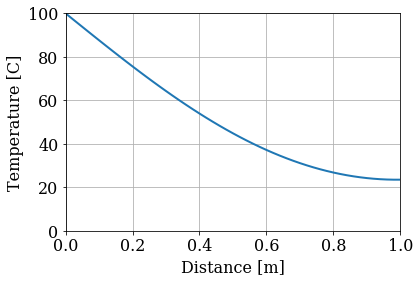

In [9]:
# plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

This is similar results we got from the explicit FTCS for $\alpha\frac{\Delta t}{\Delta x^2} = \frac{1}{2}$. If we try $\alpha\frac{\Delta t}{\Delta x^2} = 5$, it vioates the stability conditions of the explicit scheme.

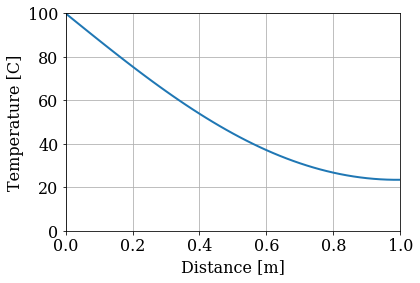

In [10]:
# increase the CFL number
sigma = 5.0
dt = sigma * dx**2 / alpha  # time-step size
nt = 100  # number of time steps to compute

# compute the temperature along the rod
T = btcs_implicit(T0, nt, dt, dx, alpha, q)

# plot the temperature along the rod
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

It did not blow up. We were not able to use such a large time step with the explicit scheme.